In [1]:
### Test 2D Ackely function

In [2]:
import torch
# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

from botorch.test_functions import Ackley

# Test the 2D Ackley function
dim = 2
ackley_function = Ackley(dim=dim)

# Define the objective function
def objective_function(X):
    return ackley_function(2*X-1)

In [3]:
maximize = False
num_iterations = 3

In [4]:
from botorch.acquisition import ExpectedImprovement
from pandora_bayesopt.utils import fit_gp_model
from botorch.optim import optimize_acqf

x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)

for i in range(num_iterations):
    
    model = fit_gp_model(x, y, input_standardize=True)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0.0], [1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)

best oberved value: 2.6375310921083046
Iteration 0, measuring at x=1.0, y=2.6375310921083046
best oberved value: 2.6375310921083046
Iteration 1, measuring at x=0.5001550745200848, y=0.0008823760845300122
best oberved value: 0.0008823760845300122
Iteration 2, measuring at x=0.3743243577841801, y=2.425177848028284
best oberved value: 0.0008823760845300122


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.]), std = tensor([0.])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.]), std = tensor([0.])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


### Test 1D Ackley

In [5]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

In [6]:
# Define the 1D Ackley function
dim = 1
ackley_function = Ackley(dim=dim)

# Define the objective function
def objective_function(X):
    return ackley_function(2*X-1)

best oberved value: 3.6253849384403627
Iteration 0, measuring at x=1.0, y=3.6253849384403627


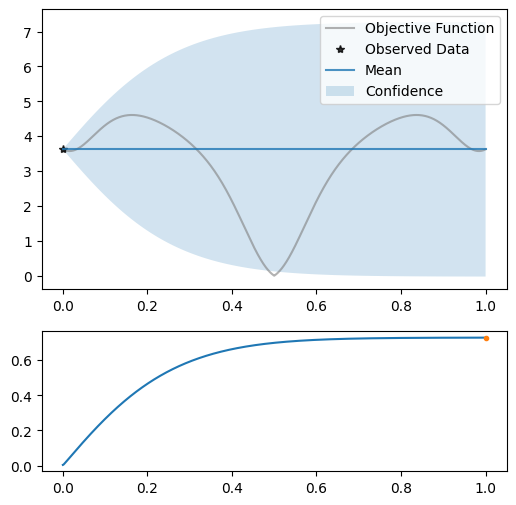

best oberved value: 3.6253849384403627
Iteration 1, measuring at x=0.5000000165250036, y=1.322000859893535e-07


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.]), std = tensor([0.])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


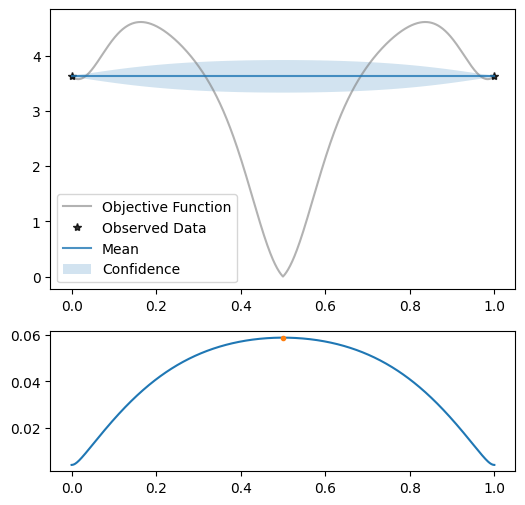

best oberved value: 1.322000859893535e-07
Iteration 2, measuring at x=0.371439584678809, y=2.764509315443903


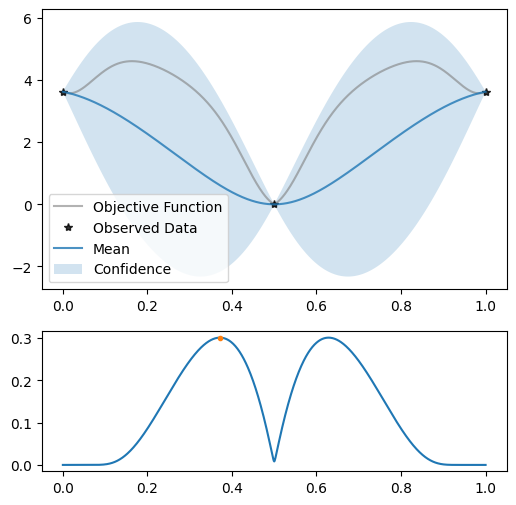

best oberved value: 1.322000859893535e-07


In [7]:
from botorch.acquisition import ExpectedImprovement
from pandora_bayesopt.utils import fit_gp_model
from botorch.optim import optimize_acqf
import matplotlib.pyplot as plt

x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)

for i in range(num_iterations):
    
    model = fit_gp_model(x, y, input_standardize=True)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0.0], [1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    test_x = torch.linspace(0, 1, 1001)
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EI
    acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)